In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models.model_config import *


## Reproducibility

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_27706/2379528797.py:2: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


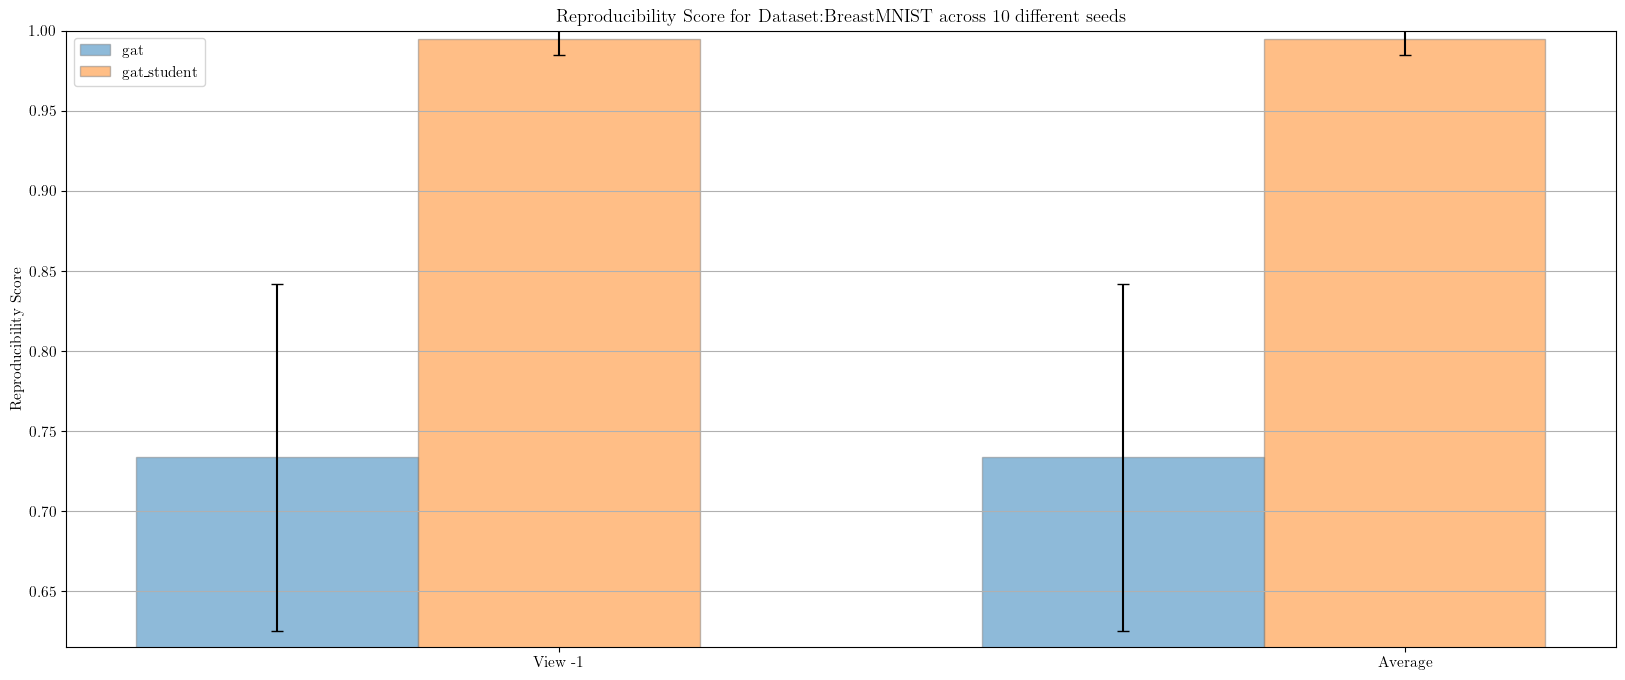

<Figure size 2000x800 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="BreastMNIST"
views=[-1]
models=["gat", "gat_student"]
model_args = [
    gat_BreastMNIST_args, 
    gat_student_gat_BreastMNIST_args
]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

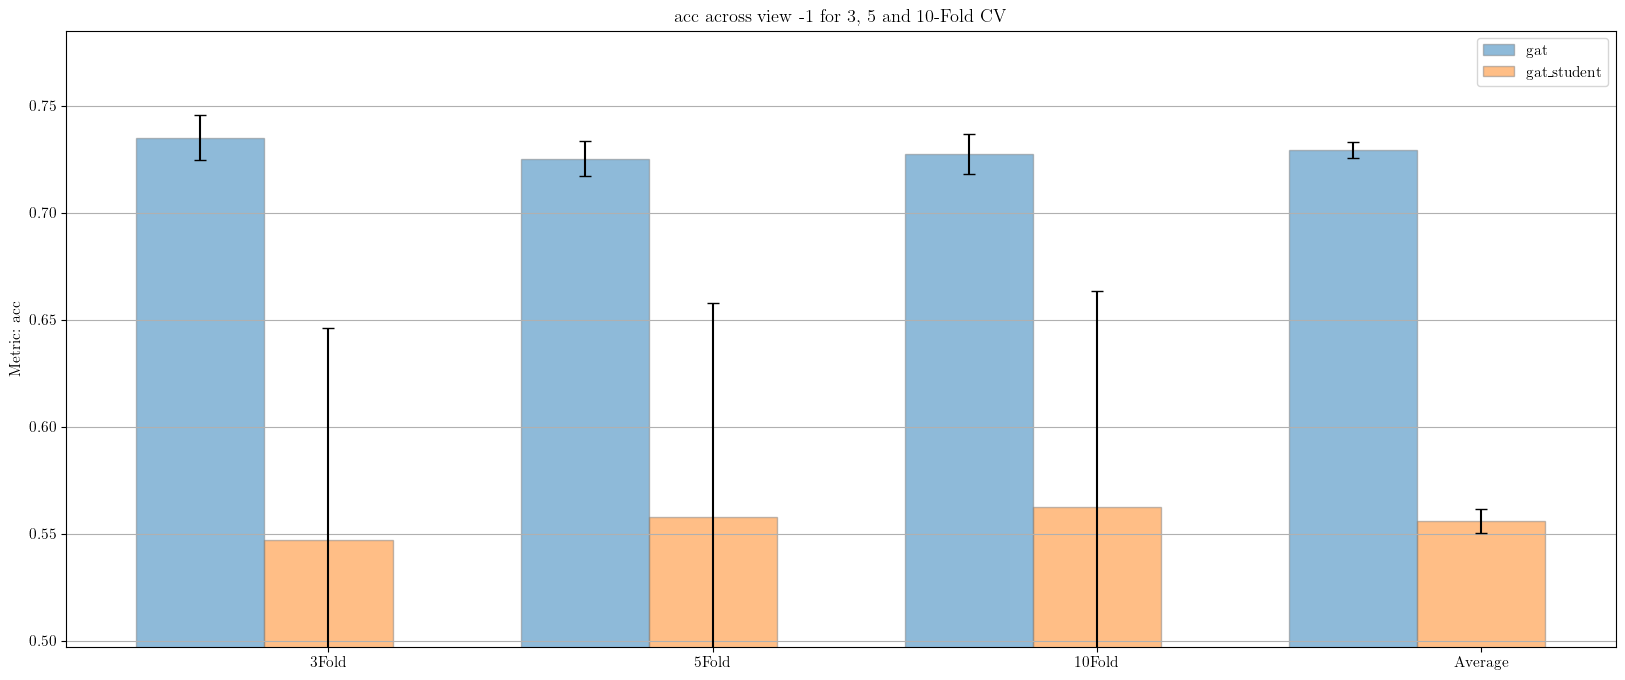

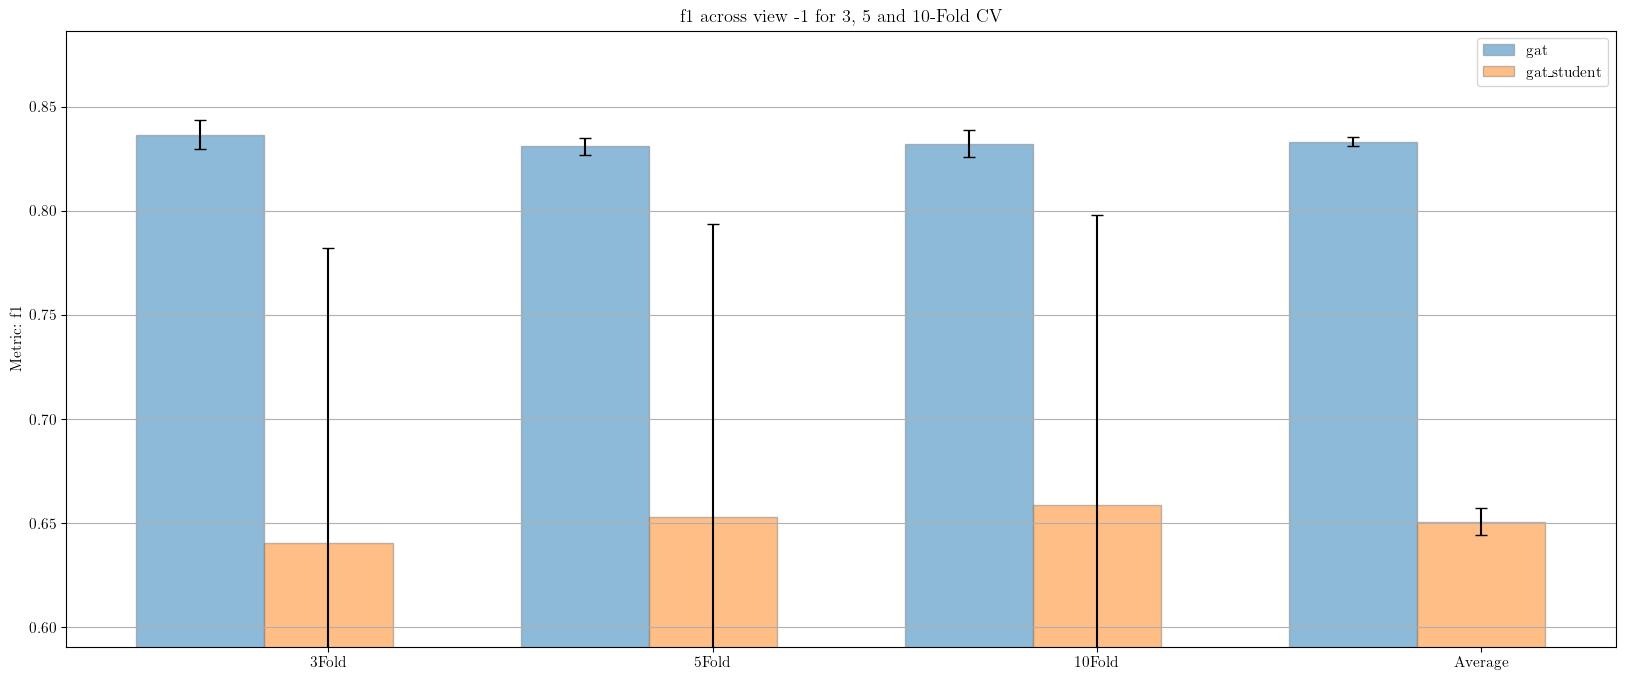

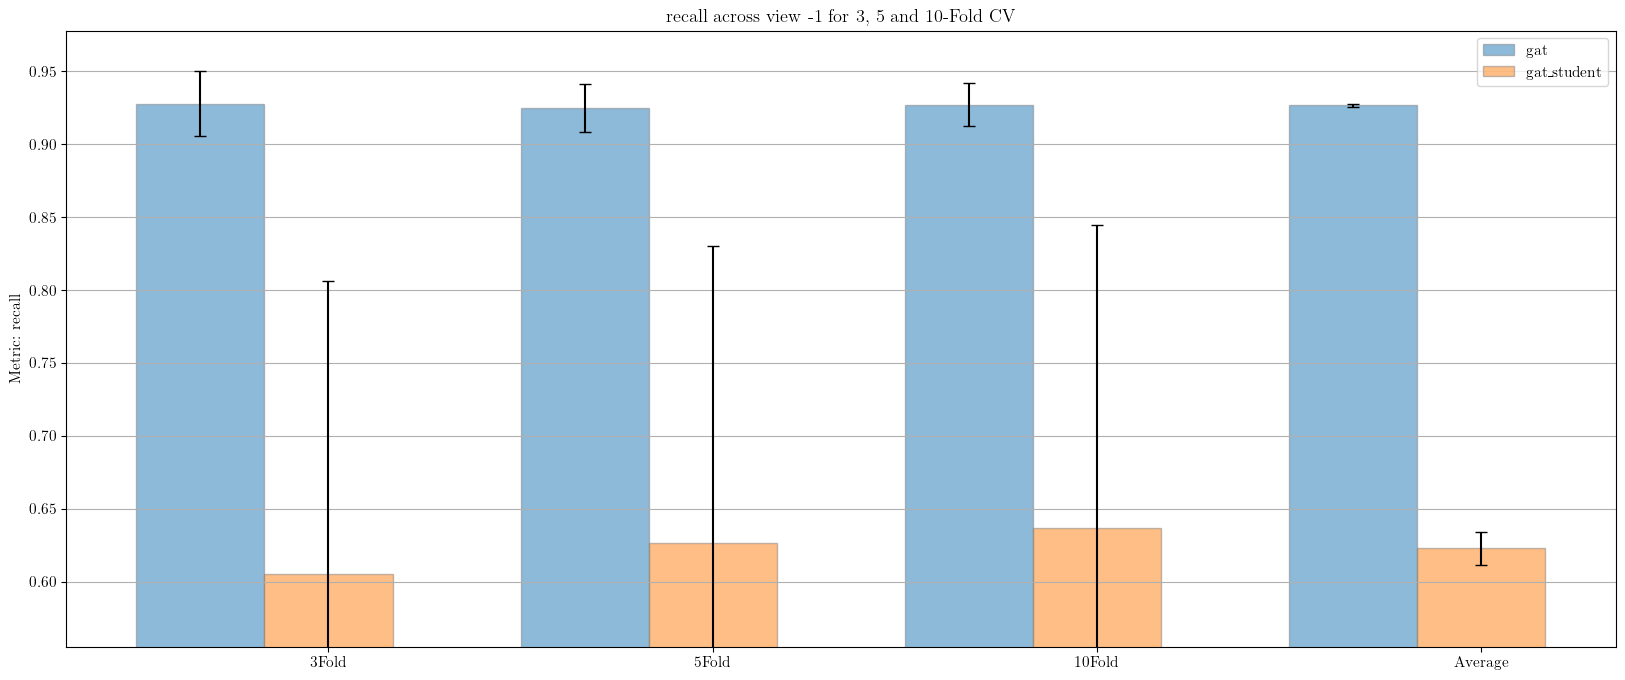

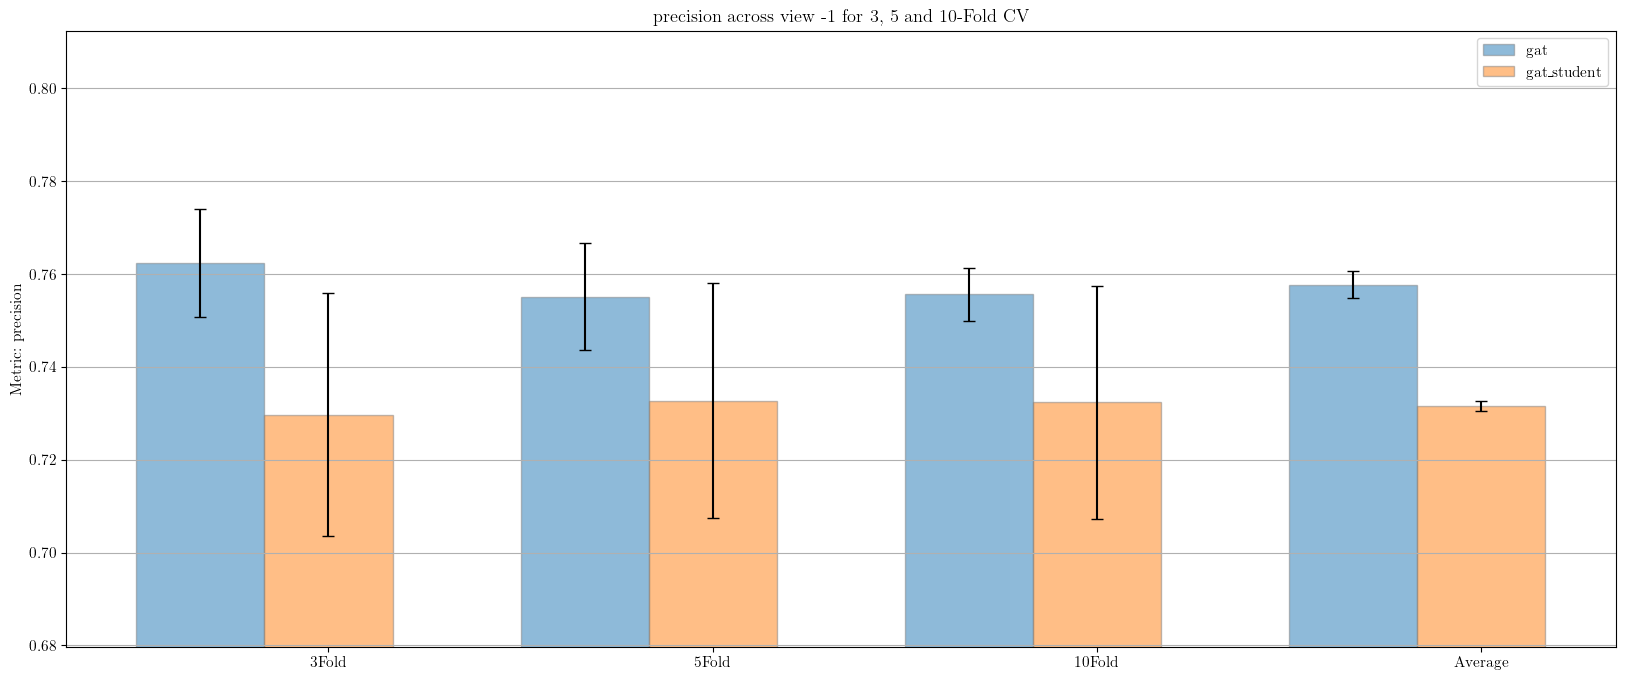

<Figure size 2000x800 with 0 Axes>

In [4]:
for view in [-1]:
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="f1", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)


# GAT ANALYSIS

In [54]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "BreastMNIST"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gat_student_lsp_ensamble_2_BreastMNIST_args,
    gat_student_lsp_ensamble_3_BreastMNIST_args,
    gat_student_lsp_ensamble_4_BreastMNIST_args,
    gat_student_lsp_ensamble_5_BreastMNIST_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    mean, var, best_students = get_best_student_ensamble_detailed(
        model=model_arg["model_name"], 
        view=-1, 
        CV=CV,
        dataset=dataset,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=model_arg
    )
    print(best_students)
    all_model_metrics_mean.append(mean)
    all_model_metrics_var.append(var)
    all_model_best_student.append(best_students)


gcn_student_lsp_ensamble_2
[[0.9404166666666667, 0.00034045138888888835, 1], [0.9404166666666667, 0.00034045138888888835, 1], [0.9404166666666667, 0.00034045138888888835, 1], [0.9404166666666667, 0.00034045138888888835, 1], [0.9404166666666667, 0.00034045138888888835, 1]]
gcn_student_lsp_ensamble_3
[[0.9718055555555555, 9.33834876543213e-05, 2], [0.9508333333333333, 0.00016828703703703792, 1], [0.9508333333333333, 0.00016828703703703792, 1], [0.9718055555555555, 9.33834876543213e-05, 2], [0.9718055555555555, 9.33834876543213e-05, 2]]
gcn_student_lsp_ensamble_4
[[0.9668055555555556, 0.0005071180555555559, 0], [0.9519444444444444, 0.00048040123456790154, 3], [0.9519444444444444, 0.00048040123456790154, 3], [0.9519444444444444, 0.00048040123456790154, 3], [0.9519444444444444, 0.00048040123456790154, 3]]
gcn_student_lsp_ensamble_5
[[0.9619444444444444, 4.791666666666632e-05, 4], [0.9284722222222221, 0.0003504050925925917, 3], [0.9284722222222221, 0.0003504050925925917, 3], [0.9619444444444

In [55]:
df_best_student = np.array(all_model_best_student)
df_metrics_var = np.array(all_model_metrics_var)
df_model_mean = np.array(all_model_metrics_mean)

In [59]:
df_model_mean[1][2], df_metrics_var[1][2], df_best_student[1]

(array([0.70773504, 0.82663909, 0.95391813, 0.72941905]),
 array([1.91577179e-06, 7.60285182e-07, 2.79060224e-06, 6.69195031e-07]),
 array([[9.71805556e-01, 9.33834877e-05, 2.00000000e+00],
        [9.50833333e-01, 1.68287037e-04, 1.00000000e+00],
        [9.50833333e-01, 1.68287037e-04, 1.00000000e+00],
        [9.71805556e-01, 9.33834877e-05, 2.00000000e+00],
        [9.71805556e-01, 9.33834877e-05, 2.00000000e+00]]))

In [72]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="BreastMNIST", 
    views=[-1], 
    models=["gat", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "gcn_student_lsp_ensamble_3"],
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2]
    ], 
    model_args = [
        gat_BreastMNIST_args, 
        gcn_student_BreastMNIST_args, 
        gat_student_BreastMNIST_args, 
        gat_fitnet_student_BreastMNIST_args,
        gat_lsp_student_BreastMNIST_args,
        gat_student_lsp_ensamble_3_BreastMNIST_args
    ])

In [73]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

models=["gat", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "gat_student_lsp_ensamble_3"]
reproducibility_frame.columns = models

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gat_student_lsp_ensamble_3"] - reproducibility_frame["gat"]) / reproducibility_frame["gat"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gat_student_lsp_ensamble_3"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100

In [74]:
reproducibility_frame

,gat,gcn_student,gcn_student_teacher,fitnet,lsp,gat_student_lsp_ensamble_3,delta teacher,delta student
0,0.733611,0.976944,0.968889,0.900556,0.92375,0.971806,32.468762,-0.526016
1,0.733611,0.976944,0.968889,0.900556,0.92375,0.971806,32.468762,-0.526016


In [78]:
from models.model_config import *

views=[-1]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gcn_student_lsp_ensamble_3"]
runs = [i for i in range(10)]
dataset = "BreastMNIST"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gat_student_lsp_ensamble_3_BreastMNIST_args]

best_student = [2]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gat", "gcn_student", "gcn_student_teacher", "fitnet", "lsp"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                            gat_BreastMNIST_args, 
                                                                                            gcn_student_BreastMNIST_args, 
                                                                                            gat_student_BreastMNIST_args, 
                                                                                            gat_fitnet_student_BreastMNIST_args,
                                                                                            gat_lsp_student_BreastMNIST_args                                                                                                            
                                                                                            ])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]
        """
        mean_df = np.array(model_mean[1])[:,i]
        mean_df = mean_df[np.newaxis, :]
    
        std_df = np.array(model_std[1])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[final_mean_df, mean_df]
        final_var_df = np.r_[final_var_df, std_df]        
        """


    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

____________________________________________________
View: -1 Metric: acc


In [79]:
models=["gat", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "gat_student_lsp_ensamble_3"]

average_across_views_df = pd.DataFrame(view_mean[0][:,-1])
average_across_views_df_mean = average_across_views_df.T

average_across_views_df_mean.columns = models
average_across_views_df_mean

average_across_views_df_mean["delta teacher"] = ((average_across_views_df_mean["gat_student_lsp_ensamble_3"] - average_across_views_df_mean["gat"]) / average_across_views_df_mean["gat"])*100
average_across_views_df_mean["delta student"] = ((average_across_views_df_mean["gat_student_lsp_ensamble_3"] - average_across_views_df_mean["gcn_student"]) / average_across_views_df_mean["gcn_student"])*100

average_across_views_df_mean

,gat,gcn_student,gcn_student_teacher,fitnet,lsp,gat_student_lsp_ensamble_3,delta teacher,delta student
0,0.729188,0.692137,0.70359,0.733718,0.736453,0.707735,-2.942038,2.253643
